In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup

In [ ]:
# -----------------------
# Hyperparameters
# -----------------------
EMBED_DIM = 64
BATCH_SIZE = 128  # per request
LR = 3e-4  # reduced learning rate for batch size 1
EPOCHS = 100
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# fix the seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# -----------------------
# Data Loading and Preprocessing
# -----------------------

# Load training data
train_df = pd.read_csv("../data/train.csv")

# We may need to ensure user_ids and book_ids are mapped to contiguous indices
# to be used as indices for embeddings. Let's create such mappings.
unique_users = train_df.user_id.unique()
unique_books = train_df.book_id.unique()

user2idx = {u: i for i, u in enumerate(unique_users)}
book2idx = {b: i for i, b in enumerate(unique_books)}

train_df["user_idx"] = train_df["user_id"].map(user2idx)
train_df["book_idx"] = train_df["book_id"].map(book2idx)

n_users = len(user2idx)
n_books = len(book2idx)

# -----------------------
# Create Validation Split
# -----------------------
# We will stratify by rating since it is a categorical-like label (1.0 to 5.0 in increments of 0.5).
# Convert rating to a string or leave as is; stratification requires discrete classes.
# Ratings are already effectively discrete steps of 0.5. We'll treat them as categories.
y = train_df["rating"].values

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(splitter.split(train_df, y))

print(f"Training samples: {train_idx}")
print(f"Validation samples: {val_idx}")

# check for any overlap
assert len(set(train_idx) & set(val_idx)) == 0

train_data = train_df.iloc[train_idx].reset_index(drop=True)
val_data = train_df.iloc[val_idx].reset_index(drop=True)

# Check for NAs (unknown users/books) - if exists, handle them:
# if test_df["user_idx"].isnull().any():
#     # If new user not in train, assign random index or handle specially.
#     # For simplicity, assign a "new_user_idx" with new embedding or use average rating.
#     # Here we just fill them with a known user (e.g., 0) - but better handle gracefully in a real scenario.
#     test_df["user_idx"].fillna(0, inplace=True)
#     test_df["user_idx"] = test_df["user_idx"].astype(int)

# if test_df["book_idx"].isnull().any():
#     # Similarly, handle unknown books:
#     test_df["book_idx"].fillna(0, inplace=True)
#     test_df["book_idx"] = test_df["book_idx"].astype(int)

Using device: mps
Training samples: [14850 33058 23165 ... 45495  9326 88037]
Validation samples: [60520 57559 83510 ... 17408 50550 45676]


In [3]:
train_data["user_id"].value_counts()

user_id
3785     1841
28251     465
43652     314
5180      302
27445     241
         ... 
92717       1
87309       1
80311       1
91709       1
92985       1
Name: count, Length: 17775, dtype: int64

In [4]:
# distribution of ratings in train and val
val_data["user_id"].value_counts()

user_id
3785     200
28251     59
5180      43
43652     36
30022     30
        ... 
92004      1
90237      1
84706      1
45609      1
51726      1
Name: count, Length: 5140, dtype: int64

In [5]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = df["user_idx"].values
        self.books = df["book_idx"].values
        self.ratings = df["rating"].values.astype(np.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.users[idx], dtype=torch.long),
            torch.tensor(self.books[idx], dtype=torch.long),
            torch.tensor(self.ratings[idx], dtype=torch.float32),
        )


train_dataset = RatingsDataset(train_data)
val_dataset = RatingsDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# -----------------------
# Model Definition
# -----------------------
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super(MatrixFactorization, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        # Optional biases
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        # Initialize embeddings
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

        # A global bias for all predictions
        self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user_ids, item_ids):
        U = self.user_emb(user_ids)
        V = self.item_emb(item_ids)
        u_b = self.user_bias(user_ids).squeeze()
        i_b = self.item_bias(item_ids).squeeze()

        # Dot product plus bias
        # user_regul = torch.norm(U, p=2)
        # item_regul = torch.norm(V, p=2)
        pred = (U * V).sum(dim=1) + u_b + i_b + self.global_bias
        return pred

In [6]:
def loss_fn(pred, target, model, reg_lambda):
    mse_loss = nn.MSELoss()(pred, target)
    user_reg = model.user_emb.weight.norm(2)
    item_reg = model.item_emb.weight.norm(2)
    reg_loss = reg_lambda * (user_reg + item_reg)
    return mse_loss + reg_loss

In [7]:
model = MatrixFactorization(n_users, n_books, EMBED_DIM).to(DEVICE)
criterion = nn.MSELoss()
# add learning rate scheduler


optimizer = optim.Adam(model.parameters(), lr=LR)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * 0.1)

# scheduler = optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=total_steps, eta_min=1e-6, num_warmup_steps=warmup_steps
# )

# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=warmup_steps,
#     num_training_steps=total_steps,
# )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)


regul_lambda = 1e-1

best_val_loss = float("inf")
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for param_group in optimizer.param_groups:
        print("Current learning rate: ", param_group["lr"])
    for users, items, ratings in tqdm(train_loader, total=len(train_loader)):
        # print the learning rate
        users = users.to(DEVICE)
        items = items.to(DEVICE)
        ratings = ratings.to(DEVICE)

        optimizer.zero_grad()
        preds = model(users, items)
        loss = loss_fn(preds, ratings, model, regul_lambda)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for users, items, ratings in tqdm(val_loader, total=len(val_loader)):
            users = users.to(DEVICE)
            items = items.to(DEVICE)
            ratings = ratings.to(DEVICE)

            preds = model(users, items)
            loss = criterion(preds, ratings)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)

    scheduler.step(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
    )
    # print rsme for both train and val
    print(
        f"RMSE Train: {np.sqrt(avg_train_loss):.4f}, RMSE Val: {np.sqrt(avg_val_loss):.4f}"
    )

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")

# Load the best model before inference
model.load_state_dict(torch.load("best_model.pt"))

# -----------------------
# Test Prediction
# -----------------------
test_df = pd.read_csv("../data/test.csv")

# Map test user/book to indices
test_df["user_idx"] = test_df["user_id"].map(user2idx).fillna(0).astype(int)
test_df["book_idx"] = test_df["book_id"].map(book2idx).fillna(0).astype(int)

model.eval()
test_users = torch.tensor(test_df["user_idx"].values, dtype=torch.long).to(DEVICE)
test_items = torch.tensor(test_df["book_idx"].values, dtype=torch.long).to(DEVICE)
with torch.no_grad():
    test_preds = model(test_users, test_items).cpu().numpy()

test_preds = np.clip(test_preds, 1.0, 5.0)

submission = pd.DataFrame({"id": test_df["id"], "rating": test_preds})
submission.to_csv("submission.csv", index=False)
print("Created submission.csv")

/Users/saidgurbuz/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 524.55it/s]


Epoch 1/100, Train Loss: 6.3106, Val Loss: 5.6600
RMSE Train: 2.5121, RMSE Val: 2.3791
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 592.05it/s]


Epoch 2/100, Train Loss: 5.1556, Val Loss: 4.7000
RMSE Train: 2.2706, RMSE Val: 2.1679
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 573.22it/s]


Epoch 3/100, Train Loss: 4.2666, Val Loss: 3.9026
RMSE Train: 2.0656, RMSE Val: 1.9755
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 649.74it/s]


Epoch 4/100, Train Loss: 3.5328, Val Loss: 3.2483
RMSE Train: 1.8796, RMSE Val: 1.8023
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 617.68it/s]


Epoch 5/100, Train Loss: 2.9347, Val Loss: 2.7189
RMSE Train: 1.7131, RMSE Val: 1.6489
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 630.87it/s]


Epoch 6/100, Train Loss: 2.4557, Val Loss: 2.2990
RMSE Train: 1.5671, RMSE Val: 1.5162
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 617.34it/s]


Epoch 7/100, Train Loss: 2.0796, Val Loss: 1.9730
RMSE Train: 1.4421, RMSE Val: 1.4046
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 596.43it/s]


Epoch 8/100, Train Loss: 1.7905, Val Loss: 1.7262
RMSE Train: 1.3381, RMSE Val: 1.3138
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 625.46it/s]


Epoch 9/100, Train Loss: 1.5739, Val Loss: 1.5439
RMSE Train: 1.2546, RMSE Val: 1.2425
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 634.52it/s]


Epoch 10/100, Train Loss: 1.4146, Val Loss: 1.4127
RMSE Train: 1.1894, RMSE Val: 1.1886
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 603.93it/s]


Epoch 11/100, Train Loss: 1.2999, Val Loss: 1.3197
RMSE Train: 1.1401, RMSE Val: 1.1488
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 604.10it/s]


Epoch 12/100, Train Loss: 1.2175, Val Loss: 1.2545
RMSE Train: 1.1034, RMSE Val: 1.1201
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 631.74it/s]


Epoch 13/100, Train Loss: 1.1573, Val Loss: 1.2075
RMSE Train: 1.0758, RMSE Val: 1.0989
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 595.06it/s]


Epoch 14/100, Train Loss: 1.1112, Val Loss: 1.1714
RMSE Train: 1.0541, RMSE Val: 1.0823
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 628.03it/s]


Epoch 15/100, Train Loss: 1.0727, Val Loss: 1.1415
RMSE Train: 1.0357, RMSE Val: 1.0684
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 625.17it/s]


Epoch 16/100, Train Loss: 1.0384, Val Loss: 1.1152
RMSE Train: 1.0190, RMSE Val: 1.0560
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 615.79it/s]


Epoch 17/100, Train Loss: 1.0067, Val Loss: 1.0909
RMSE Train: 1.0033, RMSE Val: 1.0445
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 621.73it/s]


Epoch 18/100, Train Loss: 0.9771, Val Loss: 1.0686
RMSE Train: 0.9885, RMSE Val: 1.0337
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 618.45it/s]


Epoch 19/100, Train Loss: 0.9493, Val Loss: 1.0478
RMSE Train: 0.9743, RMSE Val: 1.0236
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 617.44it/s]


Epoch 20/100, Train Loss: 0.9232, Val Loss: 1.0284
RMSE Train: 0.9608, RMSE Val: 1.0141
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 524.62it/s]


Epoch 21/100, Train Loss: 0.8987, Val Loss: 1.0101
RMSE Train: 0.9480, RMSE Val: 1.0050
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 617.23it/s]


Epoch 22/100, Train Loss: 0.8755, Val Loss: 0.9930
RMSE Train: 0.9357, RMSE Val: 0.9965
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 611.14it/s]


Epoch 23/100, Train Loss: 0.8535, Val Loss: 0.9773
RMSE Train: 0.9239, RMSE Val: 0.9886
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 623.76it/s]


Epoch 24/100, Train Loss: 0.8329, Val Loss: 0.9622
RMSE Train: 0.9127, RMSE Val: 0.9809
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 582.56it/s]


Epoch 25/100, Train Loss: 0.8134, Val Loss: 0.9481
RMSE Train: 0.9019, RMSE Val: 0.9737
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 584.84it/s]


Epoch 26/100, Train Loss: 0.7949, Val Loss: 0.9351
RMSE Train: 0.8916, RMSE Val: 0.9670
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 610.84it/s]


Epoch 27/100, Train Loss: 0.7775, Val Loss: 0.9227
RMSE Train: 0.8818, RMSE Val: 0.9606
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 612.02it/s]


Epoch 28/100, Train Loss: 0.7609, Val Loss: 0.9111
RMSE Train: 0.8723, RMSE Val: 0.9545
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 607.33it/s]


Epoch 29/100, Train Loss: 0.7452, Val Loss: 0.9004
RMSE Train: 0.8632, RMSE Val: 0.9489
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 609.60it/s]


Epoch 30/100, Train Loss: 0.7304, Val Loss: 0.8901
RMSE Train: 0.8546, RMSE Val: 0.9434
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 520.07it/s]


Epoch 31/100, Train Loss: 0.7162, Val Loss: 0.8805
RMSE Train: 0.8463, RMSE Val: 0.9384
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 530.45it/s]


Epoch 32/100, Train Loss: 0.7029, Val Loss: 0.8713
RMSE Train: 0.8384, RMSE Val: 0.9334
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 550.75it/s]


Epoch 33/100, Train Loss: 0.6901, Val Loss: 0.8629
RMSE Train: 0.8307, RMSE Val: 0.9289
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 571.16it/s]


Epoch 34/100, Train Loss: 0.6780, Val Loss: 0.8551
RMSE Train: 0.8234, RMSE Val: 0.9247
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 591.33it/s]


Epoch 35/100, Train Loss: 0.6665, Val Loss: 0.8474
RMSE Train: 0.8164, RMSE Val: 0.9206
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 578.78it/s]


Epoch 36/100, Train Loss: 0.6556, Val Loss: 0.8402
RMSE Train: 0.8097, RMSE Val: 0.9166
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 575.51it/s]


Epoch 37/100, Train Loss: 0.6451, Val Loss: 0.8335
RMSE Train: 0.8032, RMSE Val: 0.9130
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 565.46it/s]


Epoch 38/100, Train Loss: 0.6352, Val Loss: 0.8275
RMSE Train: 0.7970, RMSE Val: 0.9097
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 561.64it/s]


Epoch 39/100, Train Loss: 0.6258, Val Loss: 0.8218
RMSE Train: 0.7911, RMSE Val: 0.9066
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 576.20it/s]


Epoch 40/100, Train Loss: 0.6168, Val Loss: 0.8161
RMSE Train: 0.7853, RMSE Val: 0.9034
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 564.43it/s]


Epoch 41/100, Train Loss: 0.6081, Val Loss: 0.8111
RMSE Train: 0.7798, RMSE Val: 0.9006
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 578.47it/s]


Epoch 42/100, Train Loss: 0.5998, Val Loss: 0.8062
RMSE Train: 0.7745, RMSE Val: 0.8979
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 573.21it/s]


Epoch 43/100, Train Loss: 0.5920, Val Loss: 0.8015
RMSE Train: 0.7694, RMSE Val: 0.8953
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 578.57it/s]


Epoch 44/100, Train Loss: 0.5844, Val Loss: 0.7972
RMSE Train: 0.7645, RMSE Val: 0.8929
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 570.29it/s]


Epoch 45/100, Train Loss: 0.5771, Val Loss: 0.7932
RMSE Train: 0.7597, RMSE Val: 0.8906
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 577.14it/s]


Epoch 46/100, Train Loss: 0.5702, Val Loss: 0.7897
RMSE Train: 0.7551, RMSE Val: 0.8886
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 578.60it/s]


Epoch 47/100, Train Loss: 0.5635, Val Loss: 0.7858
RMSE Train: 0.7507, RMSE Val: 0.8865
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 581.65it/s]


Epoch 48/100, Train Loss: 0.5572, Val Loss: 0.7823
RMSE Train: 0.7465, RMSE Val: 0.8845
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 576.31it/s]


Epoch 49/100, Train Loss: 0.5511, Val Loss: 0.7795
RMSE Train: 0.7424, RMSE Val: 0.8829
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 571.10it/s]


Epoch 50/100, Train Loss: 0.5452, Val Loss: 0.7767
RMSE Train: 0.7384, RMSE Val: 0.8813
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 568.28it/s]


Epoch 51/100, Train Loss: 0.5395, Val Loss: 0.7737
RMSE Train: 0.7345, RMSE Val: 0.8796
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 567.54it/s]


Epoch 52/100, Train Loss: 0.5341, Val Loss: 0.7714
RMSE Train: 0.7308, RMSE Val: 0.8783
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 572.83it/s]


Epoch 53/100, Train Loss: 0.5289, Val Loss: 0.7690
RMSE Train: 0.7272, RMSE Val: 0.8769
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 575.53it/s]


Epoch 54/100, Train Loss: 0.5239, Val Loss: 0.7664
RMSE Train: 0.7238, RMSE Val: 0.8755
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 552.37it/s]


Epoch 55/100, Train Loss: 0.5191, Val Loss: 0.7643
RMSE Train: 0.7205, RMSE Val: 0.8743
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 562.94it/s]


Epoch 56/100, Train Loss: 0.5144, Val Loss: 0.7622
RMSE Train: 0.7172, RMSE Val: 0.8730
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 561.55it/s]


Epoch 57/100, Train Loss: 0.5099, Val Loss: 0.7606
RMSE Train: 0.7140, RMSE Val: 0.8721
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 525.21it/s]


Epoch 58/100, Train Loss: 0.5056, Val Loss: 0.7586
RMSE Train: 0.7110, RMSE Val: 0.8710
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 580.27it/s]


Epoch 59/100, Train Loss: 0.5013, Val Loss: 0.7569
RMSE Train: 0.7081, RMSE Val: 0.8700
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 590.80it/s]


Epoch 60/100, Train Loss: 0.4974, Val Loss: 0.7557
RMSE Train: 0.7053, RMSE Val: 0.8693
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 488.12it/s]


Epoch 61/100, Train Loss: 0.4935, Val Loss: 0.7541
RMSE Train: 0.7025, RMSE Val: 0.8684
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 551.73it/s]


Epoch 62/100, Train Loss: 0.4897, Val Loss: 0.7528
RMSE Train: 0.6998, RMSE Val: 0.8676
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 560.67it/s]


Epoch 63/100, Train Loss: 0.4861, Val Loss: 0.7514
RMSE Train: 0.6972, RMSE Val: 0.8669
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 533.04it/s]


Epoch 64/100, Train Loss: 0.4826, Val Loss: 0.7500
RMSE Train: 0.6947, RMSE Val: 0.8660
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 561.99it/s]


Epoch 65/100, Train Loss: 0.4792, Val Loss: 0.7490
RMSE Train: 0.6922, RMSE Val: 0.8654
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 572.22it/s]


Epoch 66/100, Train Loss: 0.4760, Val Loss: 0.7480
RMSE Train: 0.6899, RMSE Val: 0.8649
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 567.01it/s]


Epoch 67/100, Train Loss: 0.4728, Val Loss: 0.7470
RMSE Train: 0.6876, RMSE Val: 0.8643
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 570.23it/s]


Epoch 68/100, Train Loss: 0.4697, Val Loss: 0.7462
RMSE Train: 0.6854, RMSE Val: 0.8638
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 571.72it/s]


Epoch 69/100, Train Loss: 0.4668, Val Loss: 0.7453
RMSE Train: 0.6833, RMSE Val: 0.8633
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 576.91it/s]


Epoch 70/100, Train Loss: 0.4639, Val Loss: 0.7445
RMSE Train: 0.6811, RMSE Val: 0.8628
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 575.17it/s]


Epoch 71/100, Train Loss: 0.4612, Val Loss: 0.7442
RMSE Train: 0.6791, RMSE Val: 0.8627
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 572.71it/s]


Epoch 72/100, Train Loss: 0.4585, Val Loss: 0.7429
RMSE Train: 0.6772, RMSE Val: 0.8619
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 572.25it/s]


Epoch 73/100, Train Loss: 0.4559, Val Loss: 0.7424
RMSE Train: 0.6752, RMSE Val: 0.8616
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 579.82it/s]


Epoch 74/100, Train Loss: 0.4534, Val Loss: 0.7422
RMSE Train: 0.6734, RMSE Val: 0.8615
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 566.75it/s]


Epoch 75/100, Train Loss: 0.4510, Val Loss: 0.7415
RMSE Train: 0.6715, RMSE Val: 0.8611
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 579.31it/s]


Epoch 76/100, Train Loss: 0.4486, Val Loss: 0.7412
RMSE Train: 0.6698, RMSE Val: 0.8609
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 579.31it/s]


Epoch 77/100, Train Loss: 0.4463, Val Loss: 0.7410
RMSE Train: 0.6681, RMSE Val: 0.8608
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 576.63it/s]


Epoch 78/100, Train Loss: 0.4441, Val Loss: 0.7401
RMSE Train: 0.6664, RMSE Val: 0.8603
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 581.48it/s]


Epoch 79/100, Train Loss: 0.4419, Val Loss: 0.7402
RMSE Train: 0.6648, RMSE Val: 0.8603
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 588.08it/s]


Epoch 80/100, Train Loss: 0.4399, Val Loss: 0.7395
RMSE Train: 0.6632, RMSE Val: 0.8599
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 463.74it/s]


Epoch 81/100, Train Loss: 0.4378, Val Loss: 0.7393
RMSE Train: 0.6617, RMSE Val: 0.8598
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 407.46it/s]


Epoch 82/100, Train Loss: 0.4359, Val Loss: 0.7393
RMSE Train: 0.6602, RMSE Val: 0.8598
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 577.27it/s]


Epoch 83/100, Train Loss: 0.4339, Val Loss: 0.7394
RMSE Train: 0.6587, RMSE Val: 0.8599
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 582.28it/s]


Epoch 84/100, Train Loss: 0.4320, Val Loss: 0.7388
RMSE Train: 0.6573, RMSE Val: 0.8595
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 564.09it/s]


Epoch 85/100, Train Loss: 0.4302, Val Loss: 0.7387
RMSE Train: 0.6559, RMSE Val: 0.8595
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 578.20it/s]


Epoch 86/100, Train Loss: 0.4285, Val Loss: 0.7386
RMSE Train: 0.6546, RMSE Val: 0.8594
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 587.57it/s]


Epoch 87/100, Train Loss: 0.4267, Val Loss: 0.7384
RMSE Train: 0.6533, RMSE Val: 0.8593
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 595.41it/s]


Epoch 88/100, Train Loss: 0.4251, Val Loss: 0.7389
RMSE Train: 0.6520, RMSE Val: 0.8596
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 579.70it/s]


Epoch 89/100, Train Loss: 0.4234, Val Loss: 0.7386
RMSE Train: 0.6507, RMSE Val: 0.8594
Current learning rate:  0.0003


100%|██████████| 79/79 [00:00<00:00, 579.98it/s]


Epoch 90/100, Train Loss: 0.4219, Val Loss: 0.7386
RMSE Train: 0.6495, RMSE Val: 0.8594
Current learning rate:  0.00015


100%|██████████| 79/79 [00:00<00:00, 497.27it/s]


Epoch 91/100, Train Loss: 0.4182, Val Loss: 0.7385
RMSE Train: 0.6467, RMSE Val: 0.8593
Current learning rate:  0.00015


100%|██████████| 79/79 [00:00<00:00, 581.24it/s]


Epoch 92/100, Train Loss: 0.4175, Val Loss: 0.7385
RMSE Train: 0.6461, RMSE Val: 0.8593
Current learning rate:  0.00015


100%|██████████| 79/79 [00:00<00:00, 569.66it/s]


Epoch 93/100, Train Loss: 0.4167, Val Loss: 0.7386
RMSE Train: 0.6455, RMSE Val: 0.8594
Current learning rate:  7.5e-05


100%|██████████| 79/79 [00:00<00:00, 588.60it/s]


Epoch 94/100, Train Loss: 0.4149, Val Loss: 0.7386
RMSE Train: 0.6441, RMSE Val: 0.8594
Current learning rate:  7.5e-05


100%|██████████| 79/79 [00:00<00:00, 580.77it/s]


Epoch 95/100, Train Loss: 0.4145, Val Loss: 0.7385
RMSE Train: 0.6438, RMSE Val: 0.8594
Current learning rate:  7.5e-05


100%|██████████| 79/79 [00:00<00:00, 585.62it/s]


Epoch 96/100, Train Loss: 0.4142, Val Loss: 0.7386
RMSE Train: 0.6436, RMSE Val: 0.8594
Current learning rate:  3.75e-05


100%|██████████| 79/79 [00:00<00:00, 553.02it/s]


Epoch 97/100, Train Loss: 0.4133, Val Loss: 0.7386
RMSE Train: 0.6429, RMSE Val: 0.8594
Current learning rate:  3.75e-05


100%|██████████| 79/79 [00:00<00:00, 590.69it/s]


Epoch 98/100, Train Loss: 0.4131, Val Loss: 0.7386
RMSE Train: 0.6427, RMSE Val: 0.8594
Current learning rate:  3.75e-05


100%|██████████| 79/79 [00:00<00:00, 576.07it/s]


Epoch 99/100, Train Loss: 0.4129, Val Loss: 0.7386
RMSE Train: 0.6426, RMSE Val: 0.8594
Current learning rate:  1.875e-05


100%|██████████| 79/79 [00:00<00:00, 584.27it/s]
/var/folders/3w/x7g6gh3s1y1gry1przjtc12c0000gn/T/ipykernel_63475/2555662092.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

Epoch 100/100, Train Loss: 0.4124, Val Loss: 0.7386
RMSE Train: 0.6422, RMSE Val: 0.8594
Created submission.csv


In [8]:
# Load the best model before inference
model.load_state_dict(torch.load("best_model.pt"))

# -----------------------
# Test Prediction
# -----------------------
test_df = pd.read_csv("../data/test.csv")

# Map test user/book to indices
test_df["user_idx"] = test_df["user_id"].map(user2idx).fillna(0).astype(int)
test_df["book_idx"] = test_df["book_id"].map(book2idx).fillna(0).astype(int)

model.eval()
test_users = torch.tensor(test_df["user_idx"].values, dtype=torch.long).to(DEVICE)
test_items = torch.tensor(test_df["book_idx"].values, dtype=torch.long).to(DEVICE)
with torch.no_grad():
    test_preds = model(test_users, test_items).cpu().numpy()

test_preds = np.clip(test_preds, 1.0, 5.0)

submission = pd.DataFrame({"id": test_df["id"], "rating": test_preds})
submission.to_csv("submission.csv", index=False)
print("Created submission.csv")

Created submission.csv


/var/folders/3w/x7g6gh3s1y1gry1przjtc12c0000gn/T/ipykernel_63475/3997065446.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.

In [9]:
with torch.no_grad():
    test_preds = model(test_users, test_items).cpu().numpy()

In [10]:
# Validation
model.eval()
total_val_loss = 0
with torch.no_grad():
    for users, items, ratings in tqdm(val_loader, total=len(val_loader)):
        users = users.to(DEVICE)
        items = items.to(DEVICE)
        ratings = ratings.to(DEVICE)

        preds = model(users, items)
        print(preds)
        break

  0%|          | 0/79 [00:00<?, ?it/s]

tensor([2.0543, 2.9551, 3.4903, 1.8483, 1.6360, 2.0643, 3.8210, 2.0165, 1.7724,
        3.1837, 4.2414, 2.0405, 2.1744, 1.4613, 1.6319, 3.5297, 3.4007, 2.8954,
        2.4866, 1.6898, 2.1585, 1.4402, 2.7205, 3.5234, 1.8596, 2.6355, 3.4895,
        2.5656, 2.4922, 1.7234, 2.2424, 2.1147, 2.1040, 2.9382, 2.5620, 1.5521,
        2.5602, 2.9352, 1.8838, 2.5445, 1.4649, 2.0656, 3.4143, 3.7296, 3.2071,
        2.3100, 2.1794, 2.3917, 1.7804, 2.2318, 3.0523, 2.0923, 2.0183, 2.4946,
        4.4212, 1.3076, 3.7770, 3.3789, 3.2016, 1.7819, 1.9801, 2.2338, 2.0845,
        1.9194, 1.1660, 3.2080, 1.3164, 2.1437, 2.9984, 2.4302, 2.2948, 1.7942,
        2.5761, 2.5649, 3.4949, 1.6488, 2.9917, 1.7114, 1.4886, 1.5252, 3.1991,
        2.8141, 1.5899, 2.7818, 1.8650, 3.4227, 1.6317, 3.8404, 1.7439, 2.5098,
        1.0622, 2.1018, 2.4484, 3.5102, 1.8533, 1.1975, 2.3893, 2.1114, 1.7501,
        3.1841, 1.2970, 1.5769, 3.2395, 2.8440, 1.4566, 2.2203, 2.5210, 2.5208,
        2.0858, 0.7063, 3.4449, 0.9264, 

In [11]:
# initialize the model
model = MatrixFactorization(n_users, n_books, EMBED_DIM).to(DEVICE)

# load the model
model.load_state_dict(torch.load("best_model.pt"))

# predict on test data
test_df = pd.read_csv("../data/test.csv")
test_df["user_idx"] = test_df["user_id"].map(user2idx).fillna(0).astype(int)
test_df["book_idx"] = test_df["book_id"].map(book2idx).fillna(0).astype(int)

model.eval()
test_users = torch.tensor(test_df["user_idx"].values, dtype=torch.long).to(DEVICE)
test_items = torch.tensor(test_df["book_idx"].values, dtype=torch.long).to(DEVICE)

with torch.no_grad():
    test_preds = model(test_users, test_items).cpu().numpy()

/var/folders/3w/x7g6gh3s1y1gry1przjtc12c0000gn/T/ipykernel_63475/1940456524.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.

In [12]:
test_df["rating"] = np.clip(test_preds, 1.0, 5.0)

<Axes: >

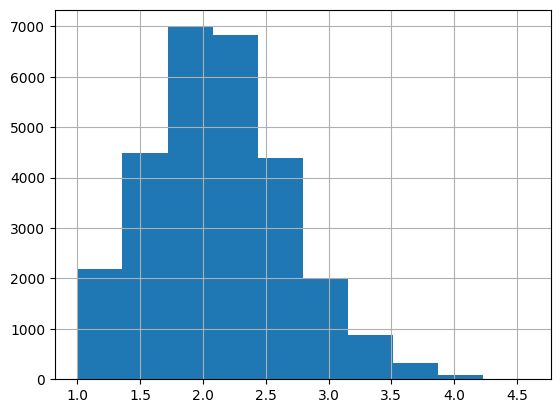

In [13]:
# get the user_ids from train set with less than 5 reviews
user_counts = train_df["user_id"].value_counts()
users_with_less_than_5_reviews = user_counts[user_counts > 2].index

# get the test_df rows with user_ids in users_with_less_than_5_reviews
test_df_filtered = test_df[test_df["user_id"].isin(users_with_less_than_5_reviews)]

# plot the ratings on hist
test_df_filtered["rating"].hist()